<a href="https://colab.research.google.com/github/shahriariit/COVID-19-Xray/blob/master/COVID19_XRay_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
from PIL import Image
from scipy import misc

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [6]:
import pandas as pd 
train = pd.read_csv('/content/drive/My Drive/Research Work/XRay/train2.csv')
print(train.shape)
 

(855, 10001)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [0]:
#sliced for DNN 
X_train = train.iloc[:, 1:]
X_train  = X_train / 255.0
y_train  = train[['10001']]

In [0]:

 # Reshape and normalize training data
X = train.iloc[:, 1:]
X  = X / 255.0
X = X.values.reshape(train.shape[0],100, 100,1).astype( 'float32' )
    
y  = train[['10001']] 

In [126]:
 
 from keras.utils import np_utils
 train


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
105,54,38,38,39,38,38,37,35,34,31,31,29,27,26,24,22,19,21,23,18,15,20,34,46,51,54,58,60,64,67,73,79,85,87,95,107,115,125,127,129,...,188,187,187,186,188,187,188,182,176,178,167,169,161,161,155,162,177,164,154,170,163,160,156,157,155,147,145,138,128,118,104,97,85,71,2,6,13,19,21,0
844,161,149,143,142,155,157,154,162,159,155,167,167,158,158,157,170,174,180,189,177,167,159,163,156,152,153,158,163,155,153,160,162,162,165,181,219,210,208,223,198,...,207,202,201,199,207,216,224,222,221,222,220,221,220,221,219,213,212,194,186,177,177,174,168,169,180,140,156,173,165,154,126,99,63,20,22,25,21,25,25,2
658,5,15,32,53,69,73,86,89,117,130,134,140,137,119,129,118,110,91,97,102,102,100,111,98,93,90,71,46,67,70,71,71,59,75,83,98,114,122,125,134,...,213,210,211,202,211,211,209,205,204,204,198,200,201,197,200,196,190,190,179,174,177,169,155,159,160,152,123,92,33,8,0,0,0,0,0,0,0,0,0,2
162,0,0,0,0,0,1,1,1,3,5,6,17,24,28,30,33,33,36,39,38,46,58,68,78,87,101,118,125,121,116,127,128,130,138,137,146,147,147,151,142,...,201,200,200,200,199,199,197,196,194,195,193,193,191,189,185,184,181,183,180,176,176,175,173,170,170,167,165,160,157,154,147,142,137,130,132,128,119,107,97,0
556,213,210,202,210,216,218,217,247,229,229,232,229,247,203,202,194,198,192,189,188,176,163,159,146,166,194,219,240,216,205,214,226,232,239,255,255,255,254,255,255,...,181,199,194,194,195,189,191,187,186,187,186,172,175,181,179,175,182,181,183,183,181,177,169,156,152,145,142,133,121,118,140,120,143,78,38,11,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,36,38,33,33,33,30,28,25,22,11,0,0,0,0,0,0,0,0,0,3,4,0,0,0,58,72,84,94,102,139,181,209,202,196,191,186,191,189,196,208,...,195,187,189,185,183,186,188,187,190,194,196,189,193,198,201,197,193,182,182,188,190,185,178,176,190,174,167,127,154,136,80,53,31,0,0,0,0,0,0,1
436,14,20,29,27,52,57,59,60,57,66,56,56,106,124,137,133,132,133,129,131,136,133,132,130,137,134,133,131,128,123,151,200,203,215,199,177,197,188,182,194,...,177,188,189,183,183,180,184,192,180,173,158,161,164,165,175,169,164,157,148,143,149,145,151,147,141,133,157,150,152,142,143,127,137,121,106,72,37,10,0,1
207,13,10,9,11,13,8,5,9,9,36,11,10,92,244,140,106,99,6,4,14,5,3,1,1,0,22,29,39,46,54,62,60,62,65,69,77,81,108,133,129,...,203,206,208,208,209,204,202,204,206,212,203,205,199,194,179,176,177,177,191,188,195,202,200,210,201,201,192,198,196,184,159,134,126,98,42,9,10,25,103,0
542,161,176,148,110,101,106,106,119,110,105,107,96,88,82,82,82,70,51,55,39,21,13,14,1,0,0,0,0,1,16,34,72,81,75,90,106,112,118,127,128,...,211,207,217,221,219,220,221,217,213,214,210,210,208,200,200,201,197,193,188,184,192,183,182,175,164,156,140,136,140,133,132,133,154,84,26,0,0,0,0,1


In [20]:

from keras.utils import to_categorical
y = to_categorical(y)
y_train = to_categorical(y_train)
y_train.shape

(855, 3)

In [0]:
def cnn_model():
    size = (100,100,1)
    num_cnn_layers =2
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [12]:
 IMAGE_SIZE = (100, 100, 1)
 model = cnn_model()

TypeError: ignored

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               19200120  
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)               

In [13]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 
from imblearn.metrics import geometric_mean_score 
from imblearn.metrics import sensitivity_score 
from imblearn.metrics import specificity_score 
from sklearn.preprocessing import label_binarize 
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import cross_val_predict 



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold,  cross_val_score
from sklearn.model_selection import cross_val_predict 


CNN = KerasClassifier(build_fn = cnn_model, epochs=50, batch_size=32, verbose=0)
#X,y = shuffle(X_train,y_train)
#DNN.fit(X_train,y_train)
y_pred = cross_val_predict(estimator = CNN, X = X, y = y, cv = 10)

#results = cross_val_score(estimator, X_train, y_train, cv=10)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [17]:


# Predicting the Test set results

print(y_pred.shape)
y =np.argmax(y,axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ",cm )
print('Accuracy :       ', accuracy_score(y, y_pred)) 
print('ROC :            ', roc_auc_score(label_binarize(y, classes=[0,1,2]), 
                                        label_binarize(y_pred, classes=[0,1,2]), average = 'weighted'))
print('Precision :      ', precision_score(y, y_pred, average='weighted')) 
print('Recall :         ', recall_score(y, y_pred, average='weighted')) 
print('F-Measure :      ', f1_score(y, y_pred, average = 'weighted'))
print('Geometric Mean : ', geometric_mean_score(y, y_pred, average = 'weighted'))
print('Sensitivity :    ', sensitivity_score(y, y_pred, average = 'weighted'))
print('Specificity :    ', specificity_score(y, y_pred, average = 'weighted'))
print('Type I Error :   ', (1-geometric_mean_score(y, y_pred, average = 'weighted')))
print('Type II Error :  ', (1-specificity_score(y, y_pred, average = 'weighted'))) 


(855,)
Confusion Matrix:  [[272   5   8]
 [  4 269  12]
 [  8  14 263]]
Accuracy :        0.9403508771929825
ROC :             0.9552631578947368
Precision :       0.9403676261863814
Recall :          0.9403508771929825
F-Measure :       0.9403458608293845
Geometric Mean :  0.9551467555906249
Sensitivity :     0.9403508771929825
Specificity :     0.9701754385964912
Type I Error :    0.044853244409375104
Type II Error :   0.029824561403508754


In [18]:
print(y.shape)

(855,)


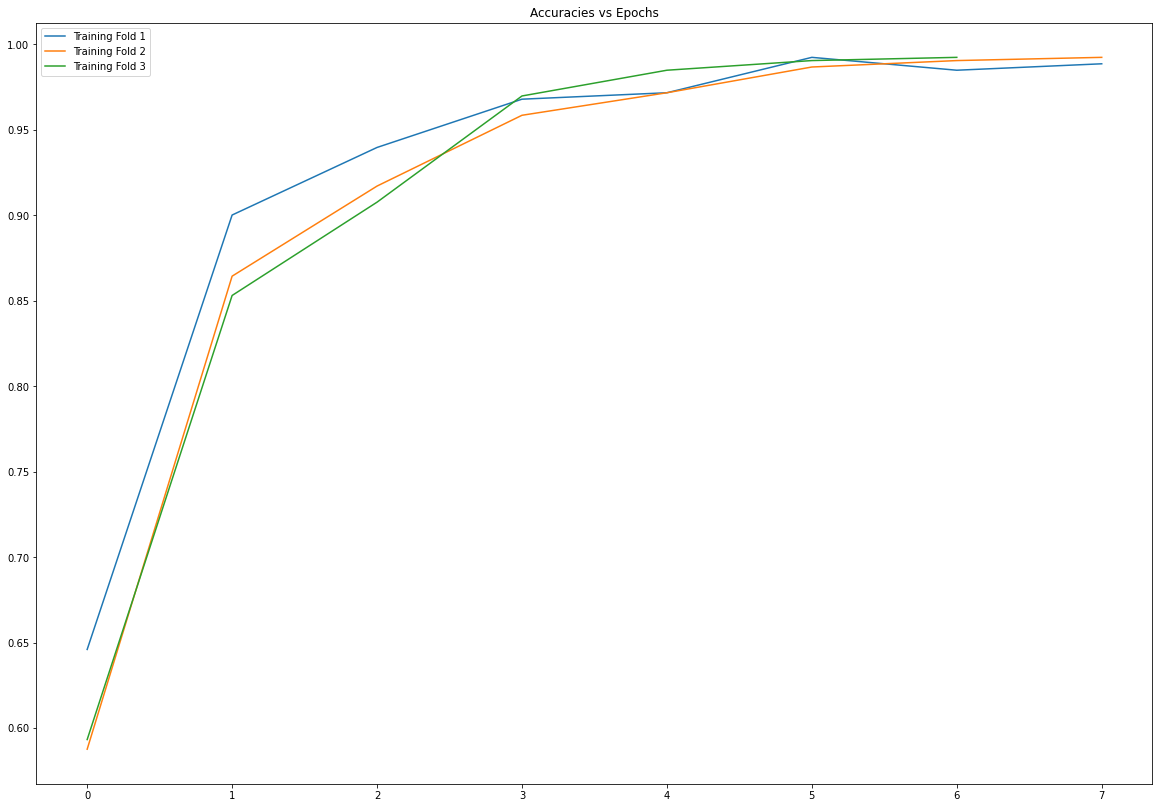

In [0]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

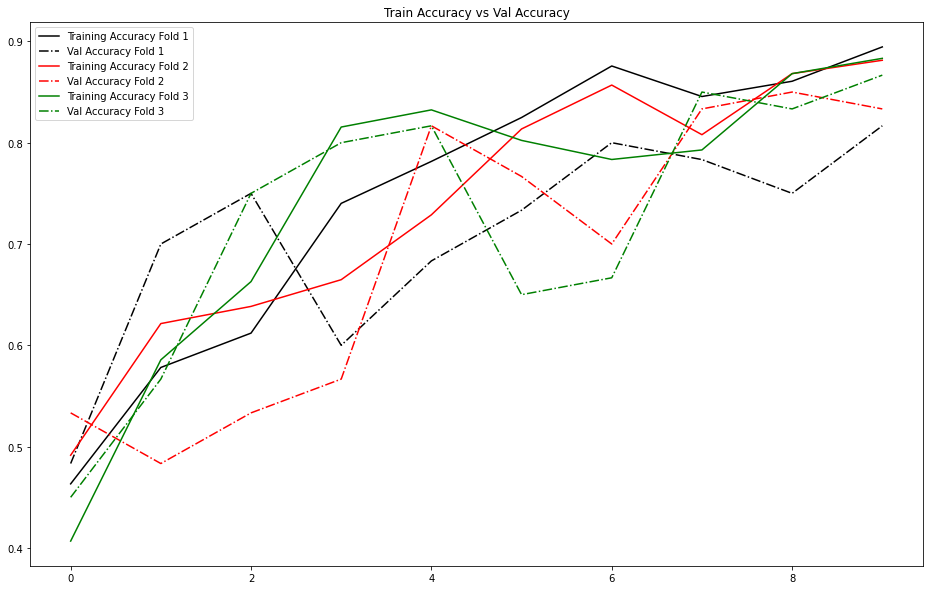

In [0]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='green')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")



plt.legend()
plt.show()

In [0]:
model = DNN()
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 512)               5120512   
_________________________________________________________________
dense_125 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_126 (Dense)            (None, 3)                 1539      
Total params: 5,384,707
Trainable params: 5,384,707
Non-trainable params: 0
_________________________________________________________________


In [0]:
def DNN():
  
  model =  Sequential()
  model.add(Dense(units=512, input_dim=10000,
    activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=512,
    activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold,  cross_val_score
from sklearn.model_selection import cross_val_predict 


DNN = KerasClassifier(build_fn = DNN, epochs=50, batch_size=32, verbose=0)
#X,y = shuffle(X_train,y_train)
#DNN.fit(X_train,y_train)
y_pred = cross_val_predict(estimator = DNN, X = X_train, y = y_train, cv = 10)

#results = cross_val_score(estimator, X_train, y_train, cv=10)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [23]:


# Predicting the Test set results

print(y_pred.shape)
y_train =np.argmax(y_train,axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix: ",cm )
print('Accuracy :       ', accuracy_score(y_train, y_pred)) 
print('ROC :            ', roc_auc_score(label_binarize(y_train, classes=[0,1,2]), 
                                        label_binarize(y_pred, classes=[0,1,2]), average = 'weighted'))
print('Precision :      ', precision_score(y_train, y_pred, average='weighted')) 
print('Recall :         ', recall_score(y_train, y_pred, average='weighted')) 
print('F-Measure :      ', f1_score(y_train, y_pred, average = 'weighted'))
print('Geometric Mean : ', geometric_mean_score(y_train, y_pred, average = 'weighted'))
print('Sensitivity :    ', sensitivity_score(y_train, y_pred, average = 'weighted'))
print('Specificity :    ', specificity_score(y_train, y_pred, average = 'weighted'))
print('Type I Error :   ', (1-geometric_mean_score(y_train, y_pred, average = 'weighted')))
print('Type II Error :  ', (1-specificity_score(y_train, y_pred, average = 'weighted'))) 


(855,)
Confusion Matrix:  [[201   8  76]
 [  1 246  38]
 [ 11 120 154]]
Accuracy :        0.7029239766081872
ROC :             0.7771929824561403
Precision :       0.7253476160659382
Recall :          0.7029239766081872
F-Measure :       0.7035922256475624
Geometric Mean :  0.773636249635077
Sensitivity :     0.7029239766081872
Specificity :     0.8514619883040936
Type I Error :    0.22636375036492296
Type II Error :   0.1485380116959064


In [147]:
#print(cm)
print(accuracy_score(y_train,y_pred))
print(X_train.shape)
print(y_train.shape)

0.7910331384015594
(855, 10000)
(2565,)


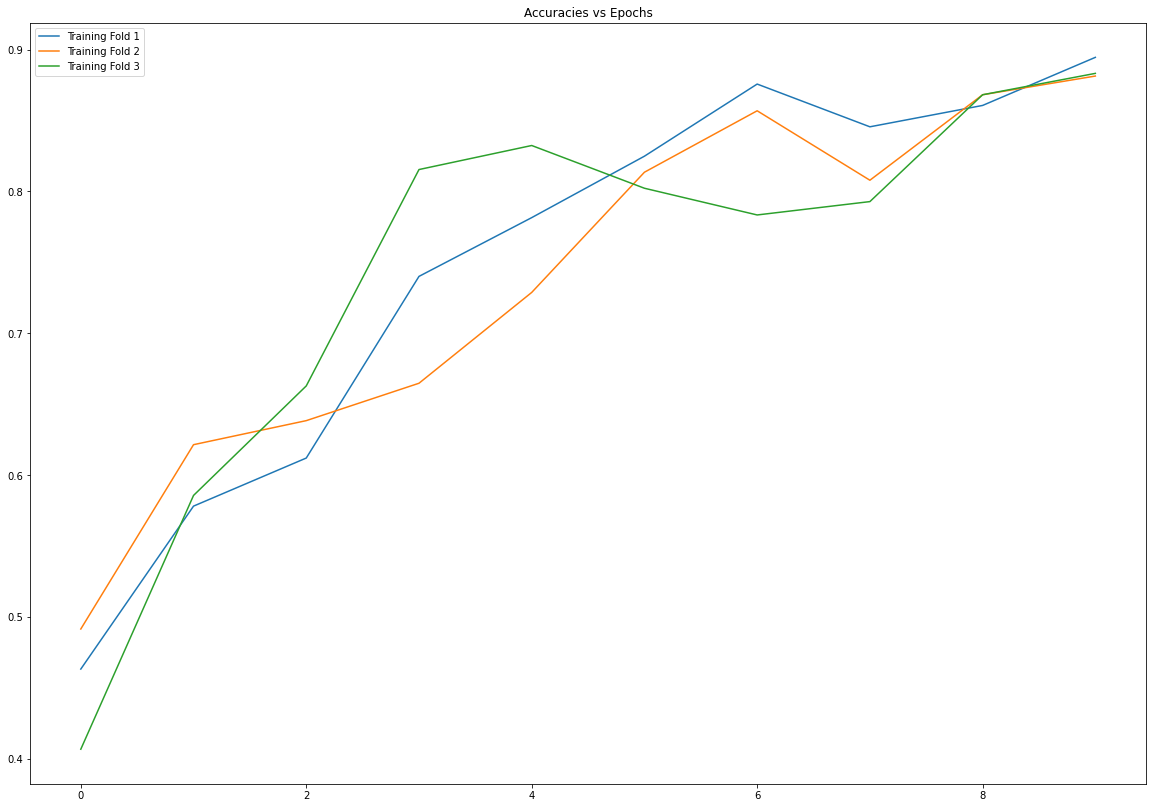

In [0]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

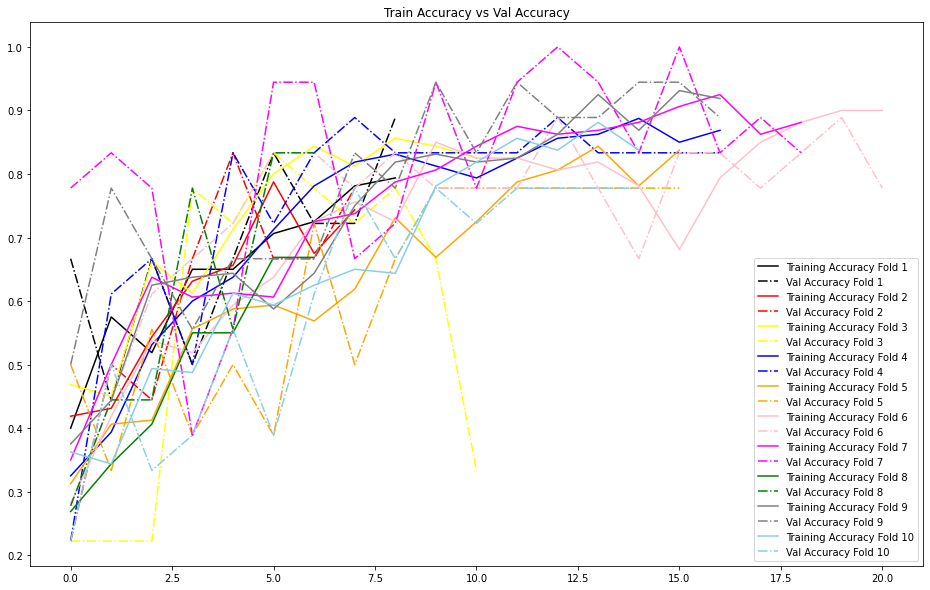

In [0]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='yellow')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Training Accuracy Fold 4',color='blue')

plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Training Accuracy Fold 5',color='orange')

plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Training Accuracy Fold 6',color='pink')

plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
plt.plot(model_history[6].history['accuracy'], label='Training Accuracy Fold 7',color='magenta')

plt.plot(model_history[6].history['val_accuracy'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
plt.plot(model_history[7].history['accuracy'], label='Training Accuracy Fold 8',color='green')

plt.plot(model_history[7].history['val_accuracy'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
plt.plot(model_history[8].history['accuracy'], label='Training Accuracy Fold 9',color='gray')

plt.plot(model_history[8].history['val_accuracy'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['accuracy'], label='Training Accuracy Fold 10',color='skyblue')
plt.plot(model_history[9].history['val_accuracy'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()

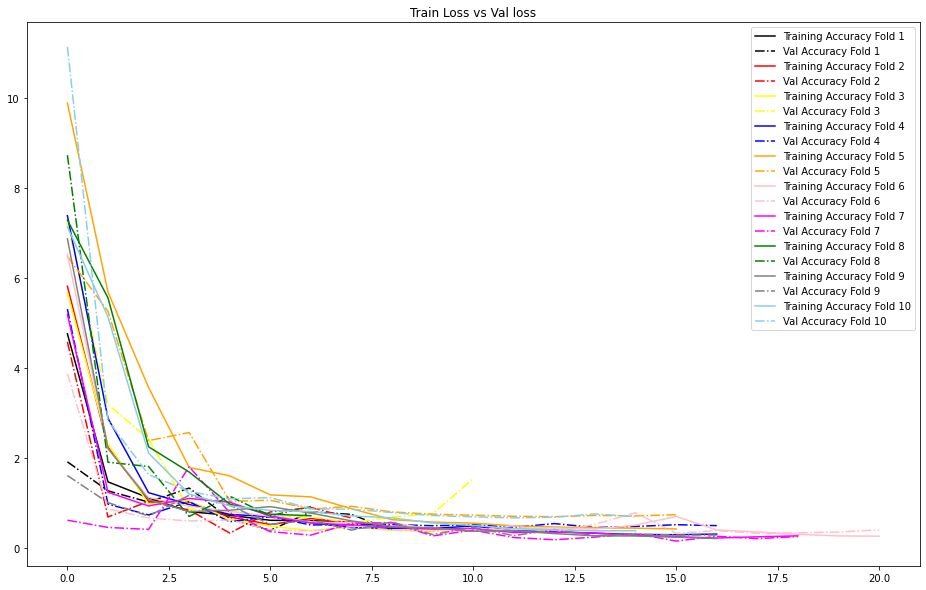

In [0]:
plt.title('Train Loss vs Val loss')
 
plt.plot(model_history[0].history['loss'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Training Accuracy Fold 3',color='yellow')

plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Training Accuracy Fold 4',color='blue')

plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Training Accuracy Fold 5',color='orange')

plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt.plot(model_history[5].history['loss'], label='Training Accuracy Fold 6',color='pink')

plt.plot(model_history[5].history['val_loss'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
plt.plot(model_history[6].history['loss'], label='Training Accuracy Fold 7',color='magenta')

plt.plot(model_history[6].history['val_loss'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
plt.plot(model_history[7].history['loss'], label='Training Accuracy Fold 8',color='green')

plt.plot(model_history[7].history['val_loss'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
plt.plot(model_history[8].history['loss'], label='Training Accuracy Fold 9',color='gray')

plt.plot(model_history[8].history['val_loss'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['loss'], label='Training Accuracy Fold 10',color='skyblue')
plt.plot(model_history[9].history['val_loss'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()

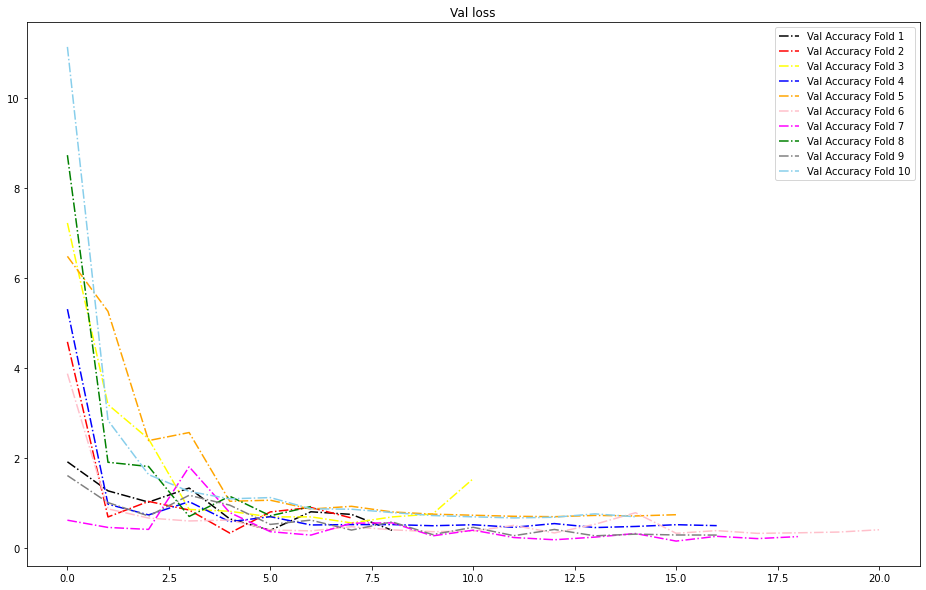

In [0]:
plt.title('Val loss')
 
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")

plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
 
plt.plot(model_history[5].history['val_loss'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
 
plt.plot(model_history[6].history['val_loss'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
 
plt.plot(model_history[7].history['val_loss'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
 
plt.plot(model_history[8].history['val_loss'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['val_loss'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()